In [45]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

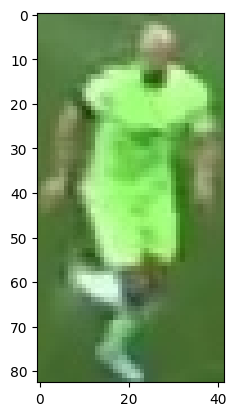

In [10]:
img = cv2.imread('../croppedimg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

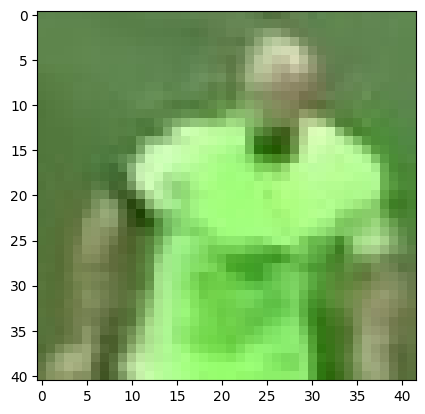

In [11]:
top_half_img = img[0:img.shape[0]//2, 0:img.shape[1]]
plt.imshow(top_half_img)

In [32]:
image_2d = top_half_img.reshape(-1, 3)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1)
kmeans.fit(image_2d)

labels = kmeans.labels_
center_clusters = kmeans.cluster_centers_

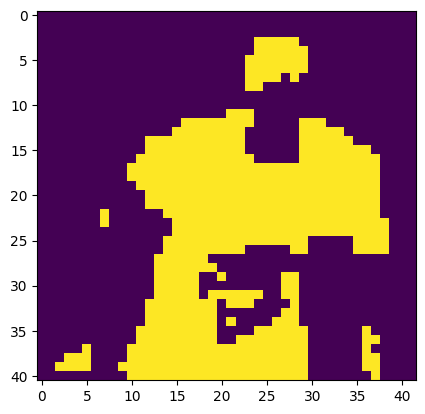

In [33]:
# show the image after clustering
clustred_image = labels.reshape(top_half_img.shape[0], top_half_img.shape[1])
plt.imshow(clustred_image)

In [34]:
corner_cluster = [clustred_image[0,0], clustred_image[0,-1], clustred_image[-1,0], clustred_image[-1,-1]]
corner_cluster
non_player = max(set(corner_cluster), key=corner_cluster.count)
player = 1 - non_player
player

1

In [35]:
center_clusters[player]

array([159.12014134, 229.56713781, 126.9664311 ])

## make clustring on the color distribution of the image

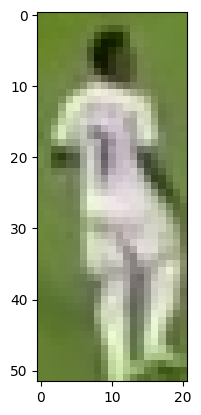

In [37]:
img = cv2.imread('../players_frame.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [38]:
img.shape

(52, 21, 3)

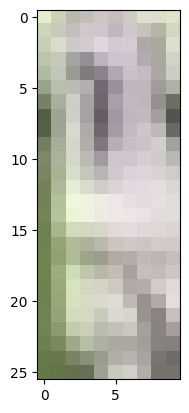

In [39]:
image_center_box = img[img.shape[0]//4:3*img.shape[0]//4, img.shape[1]//4:3*img.shape[1]//4]
plt.imshow(image_center_box)

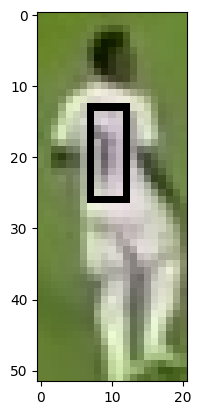

In [40]:
img2 = img.copy()
cv2.rectangle(img2, (img2.shape[1]//3, img2.shape[0]//4), (3*img2.shape[1]//5, 2*img2.shape[0]//4), (0, 0, 0), 1)
plt.imshow(img2)

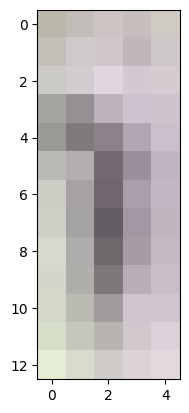

In [41]:
img_cropped = img[img2.shape[0]//4:(2*img2.shape[0])//4, img2.shape[1]//3:(3*img2.shape[1])//5]

plt.imshow(img_cropped)

In [42]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=1)
kmeans.fit(img_cropped.reshape(-1, 3))

labels = kmeans.labels_
center_clusters = kmeans.cluster_centers_

<BarContainer object of 5 artists>

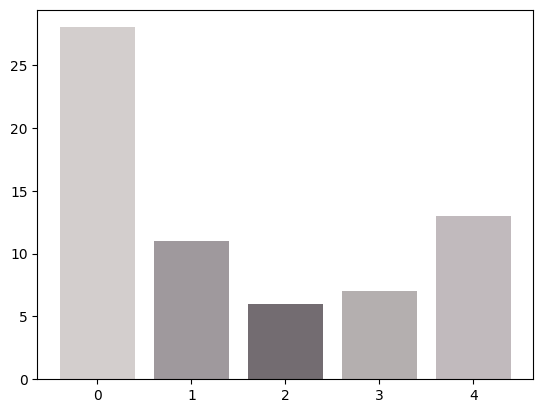

In [43]:
plt.bar(range(5), [sum(labels==i) for i in range(5)], color=[center_clusters[i]/255 for i in range(5)])

In [51]:
# get the avrage color of high two clusters
player_color = center_clusters[np.argsort([sum(labels==i) for i in range(5)])]
# take avrage of the two highest clusters
player_color = np.mean(player_color[:2], axis=0)
player_color

array([147.5       , 141.3452381 , 144.16666667])

In [50]:
max_color = center_clusters[np.argmax([sum(labels==i) for i in range(5)])]
max_color

array([211.39285714, 206.32142857, 205.46428571])